In [5]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import statistics
import random


tour_num = 3
cross_prob = 0.9
mutation_prob = 0.1

epochs = 30
simulations = 3
population_size = 40
elite_individuals_num = 3

nn_structures = [(4, 1), (4, 2, 1), (4, 8, 1), (4, 2, 4, 1), (4, 8, 2, 1)]
individual_lengths = [sum([(nn_structure[i] + 1) * nn_structure[i + 1] 
                           for i in range(len(nn_structure) - 1)]) for nn_structure in nn_structures]

unit_cross_prob = 0.5
unit_mutation_probs = tuple([10 / individual_length for individual_length in individual_lengths])

testing_simulations = 5
print_information = True
max_fitness_counter = 1000
nn_num = len(nn_structures)


class Neuron:
    def __init__(self, num_inputs):
        self.weights = np.random.rand(num_inputs)
        self.bias = np.random.rand()

    def set_weights_and_bias(self, weights, bias):
        self.weights = weights
        self.bias = bias

    def step_activation(self, x):
        return 1 if x >= 0 else 0

    def relu_activation(self, x):
        return max(0, x)


class NeuralNetwork:
    def __init__(self, num_inputs, *num_neurons_per_layer):
        self.nn_structure = (num_inputs, *num_neurons_per_layer)
        self.layers = []

        for num_neurons in num_neurons_per_layer:
            layer = [Neuron(num_inputs) for _ in range(num_neurons)]
            self.layers.append(layer)
            num_inputs = num_neurons

    def set_weights_and_biases(self, weights_list, biases_list):
        for layer, weights, biases in zip(self.layers, weights_list, biases_list):
            for neuron, w, b in zip(layer, weights, biases):
                neuron.set_weights_and_bias(w, b)

    def predict(self, inputs):
        outputs = inputs
        for layer in self.layers:
            new_outputs = []
            for neuron in layer:
                net_input = np.dot(neuron.weights, outputs) + neuron.bias
                if layer is self.layers[-1]:
                    new_outputs.append(neuron.step_activation(net_input))
                else:
                    new_outputs.append(neuron.relu_activation(net_input))
            outputs = new_outputs
        return outputs[0]


class NeuralNetworkEnsemble:
    def __init__(self, nn_structures):
        self.networks = [NeuralNetwork(*nn_structure) for nn_structure in nn_structures]

    def set_weights_and_biases(self, weights_list, biases_list):
        for network, weights, biases in zip(self.networks, weights_list, biases_list):
            network.set_weights_and_biases(weights, biases)

    def predict(self, inputs):
        predictions = [network.predict(inputs) for network in self.networks]
        avg_predict = 0 if predictions.count(0) > predictions.count(1) else 1
        return avg_predict


class Individual:
    def __init__(self, length, chrom=None):
        self.chromosome = np.random.uniform(-1, 1, length) if chrom is None else chrom

    def set_parameters(self, fitness=None, max_position=None):
        self.max_position = float('inf') if max_position is None else max_position
        self.fitness = 0 if fitness is None else fitness


def create_population(population_size, individual_lengths, nn_num):
    populations = [[Individual(individual_length) for _ in range(population_size)] 
                   for individual_length in individual_lengths]
    return populations


def tournament_selection(populations, quantity, tour_num):
    new_populations = [[max(random.sample(population, tour_num), 
                          key=lambda x: (x.fitness, -x.max_position)) for _ in range(quantity)] 
                       for population in populations]
    return new_populations


def crossing(individual_1, individual_2, individual_length, unit_cross_prob):
    for i in range(individual_length):
        if random.random() < unit_cross_prob :
            individual_1.chromosome[i], individual_2.chromosome[i] = individual_2.chromosome[i], individual_1.chromosome[i]


def mutation(individual, individual_length, unit_mutation_prob):
    for i in range(individual_length):
        if random.random() < unit_mutation_prob:
            individual.chromosome[i] = random.triangular(-1, 1, individual.chromosome[i])


def clone_individual(individual_length, ind):
    new_individual = Individual(individual_length, ind.chromosome.copy())
    new_individual.set_parameters(ind.fitness, ind.max_position)
    return new_individual


def converting_individual(nn_structure, individual):
    chromosome = individual.chromosome
    weights_list = []
    biases_list = []
    start_index = 0

    for i in range(len(nn_structure) - 1):
        num_neurons_current_layer = nn_structure[i]
        num_neurons_next_layer = nn_structure[i + 1]
        weights = []

        for _ in range(num_neurons_next_layer):
            weights.append(chromosome[start_index:start_index + num_neurons_current_layer])
            start_index += num_neurons_current_layer

        weights_list.append(weights)
        biases_list.append(chromosome[start_index:start_index + num_neurons_next_layer])
        start_index += num_neurons_next_layer

    return weights_list, biases_list


def count_parameters(env, model, simulations):

    max_fitness = 0
    max_position = 0
    fitness_counter = 0

    for _ in range(simulations):
        observation, info = env.reset()
        intermediate_fitness_counter = 0
        intermediate_max_position = 0
        done = False

        while not done:
            action = model.predict(observation)
            observation, reward, done, false, info = env.step(action)
            intermediate_max_position = max(abs(observation[0]), intermediate_max_position)
            intermediate_fitness_counter += reward

            if intermediate_fitness_counter >= max_fitness_counter: 
                break

        max_position += intermediate_max_position
        max_fitness = max(max_fitness, intermediate_fitness_counter)
        fitness_counter += intermediate_fitness_counter

    return fitness_counter, max_fitness, max_position


def testing_model(best_individuals, model, env, max_fitness_counter, testing_simulations):
    
    all_weights = []
    all_biases = []
    
    for ind, network in zip(best_individuals, model.networks):
        weights, biases = converting_individual(network.nn_structure, ind)
        all_weights.append(weights)
        all_biases.append(biases)

    model.set_weights_and_biases(all_weights, all_biases)
    fitness_counter, max_fitness, _ = count_parameters(env, model, testing_simulations)

    avg_fitness = round(fitness_counter / testing_simulations, 1)
    return max_fitness, avg_fitness


def count_individual_parameters(individual, network, env, max_fitness_counter, simulations):

    weights, biases = converting_individual(network.nn_structure, individual)
    network.set_weights_and_biases(weights, biases)
    
    fitness_counter, _, max_position = count_parameters(env, network, simulations)
    fitness_counter /= simulations
    max_position /= simulations

    return fitness_counter, max_position


def count_population_parameters(max_fit, avg_fit, model, env, populations, 
                                max_fitness_counter, simulations, testing_simulations):
    
    best_individuals = []
    for population, network in zip(populations, model.networks):
        
        fitness_list = []
        for ind in population:
            ind.set_parameters(*count_individual_parameters(ind, network, env, max_fitness_counter, simulations))
            fitness_list.append(ind.fitness)
            
        best_individuals.append(sorted(population, key=lambda x: (x.fitness, -x.max_position))[-1])
        
    max_fitness, avg_fitness = testing_model(best_individuals, model, env, max_fitness_counter, testing_simulations)
    max_fit.append(max_fitness)
    avg_fit.append(avg_fitness)

    return max_fit, avg_fit


def print_stats(epoch=None, max_fit=None, avg_fit=None, start=False, end=False, print_information=True):
    
    if print_information:
        
        epoch_spaces = ' ' * (6 - len(str(epoch)))
        max_fit_spaces = ' ' * (8 - len(str(max_fit)))
        avg_fit_spaces = ' ' * (8 - len(str(avg_fit)))

        if start:
            print("┌───────┬─────────┬─────────┐\n│ EPOCH │ MAXIMUM │ AVERAGE │\n├───────┼─────────┼─────────┤")
        else:
            print(f"│ {epoch}{epoch_spaces}│ {max_fit}{max_fit_spaces}│ {avg_fit}{avg_fit_spaces}│")
        if end:
            print("└───────┴─────────┴─────────┘")


def genetic_algorithm(env, model, nn_num, populations, population_size, individual_lengths, epochs, 
                      elite_individuals_num, cross_prob, unit_cross_prob, mutation_prob, unit_mutation_probs, 
                      tour_num, max_fitness_counter, simulations, testing_simulations, print_information):
    max_fit = []
    avg_fit = []
    
    best_individuals = [Individual(individual_length) for individual_length in individual_lengths]
    
    for individual, network in zip(best_individuals, model.networks):
        individual.set_parameters(*count_individual_parameters(individual, network, env, max_fitness_counter, simulations))
        
    print_stats(start=True, print_information=print_information)

    for epoch in range(epochs):
        max_fit, avg_fit = count_population_parameters(max_fit, avg_fit, model, env, populations, 
                                                       max_fitness_counter, simulations, testing_simulations)

        print_stats(epoch, max_fit[-1], avg_fit[-1], print_information=print_information)

        elite_individuals = [sorted(population, key=lambda x: (x.fitness, -x.max_position))[-elite_individuals_num:] 
                             for population in populations]
        
        best_individuals = [max(*elite_ind, best_ind, key=lambda x: (x.fitness, -x.max_position)) 
                            for best_ind, elite_ind in zip(best_individuals, elite_individuals)]
        
        quantity = population_size - elite_individuals_num
        populations = tournament_selection(populations, quantity, tour_num)

        populations_copy = [[clone_individual(individual_length, population[i]) for i in range(quantity)] 
                            for population, individual_length in zip(populations, individual_lengths)]
        
        for n in range(nn_num):
            populations_copy[n].extend(elite_individuals[n])
            random.shuffle(populations_copy[n])
            
            for individual_1, individual_2 in zip(populations_copy[n][::2], populations_copy[n][1::2]):
                if random.random() < cross_prob:
                    crossing(individual_1, individual_2, individual_lengths[n], unit_cross_prob)

            for ind in populations_copy[n]:
                if random.random() < mutation_prob:
                    mutation(ind, individual_lengths[n], unit_mutation_probs[n])

            populations[n][:] = populations_copy[n]

    max_fit, avg_fit = count_population_parameters(max_fit, avg_fit, model, env, populations, 
                                                   max_fitness_counter, simulations, testing_simulations)
    
    best_individuals = [max(*population, best_individual, key=lambda x: (x.fitness, -x.max_position)) 
                        for population, best_individual in zip(populations, best_individuals)]
    
    print_stats(epochs, max_fit[-1], avg_fit[-1], end=True, print_information=print_information)
    return max_fit, avg_fit, best_individuals


In [6]:
env = gym.make('CartPole-v1')
model = NeuralNetworkEnsemble(nn_structures)
populations = create_population(population_size, individual_lengths, nn_num)

max_fit, avg_fit, best_individuals = genetic_algorithm(env, model, nn_num, populations, population_size, individual_lengths,
                                                       epochs, elite_individuals_num, cross_prob, unit_cross_prob, 
                                                       mutation_prob, unit_mutation_probs, tour_num, max_fitness_counter, 
                                                       simulations, testing_simulations, print_information)


┌───────┬─────────┬─────────┐
│ EPOCH │ MAXIMUM │ AVERAGE │
├───────┼─────────┼─────────┤
│ 0     │ 88.0    │ 59.4    │
│ 1     │ 72.0    │ 55.2    │
│ 2     │ 111.0   │ 98.0    │
│ 3     │ 212.0   │ 187.4   │
│ 4     │ 301.0   │ 191.0   │
│ 5     │ 85.0    │ 74.2    │
│ 6     │ 211.0   │ 130.2   │
│ 7     │ 1000.0  │ 509.0   │
│ 8     │ 1000.0  │ 302.4   │
│ 9     │ 1000.0  │ 476.8   │
│ 10    │ 1000.0  │ 305.4   │
│ 11    │ 1000.0  │ 567.6   │
│ 12    │ 1000.0  │ 517.0   │
│ 13    │ 1000.0  │ 361.8   │
│ 14    │ 1000.0  │ 480.2   │
│ 15    │ 1000.0  │ 674.8   │
│ 16    │ 1000.0  │ 654.8   │
│ 17    │ 1000.0  │ 604.4   │
│ 18    │ 1000.0  │ 839.6   │
│ 19    │ 1000.0  │ 494.0   │
│ 20    │ 1000.0  │ 935.2   │
│ 21    │ 1000.0  │ 504.4   │
│ 22    │ 1000.0  │ 713.8   │
│ 23    │ 1000.0  │ 828.6   │
│ 24    │ 1000.0  │ 407.6   │
│ 25    │ 1000.0  │ 546.2   │
│ 26    │ 1000.0  │ 474.2   │
│ 27    │ 1000.0  │ 686.0   │
│ 28    │ 1000.0  │ 1000.0  │
│ 29    │ 1000.0  │ 1000.0  │
│ 30    │ 

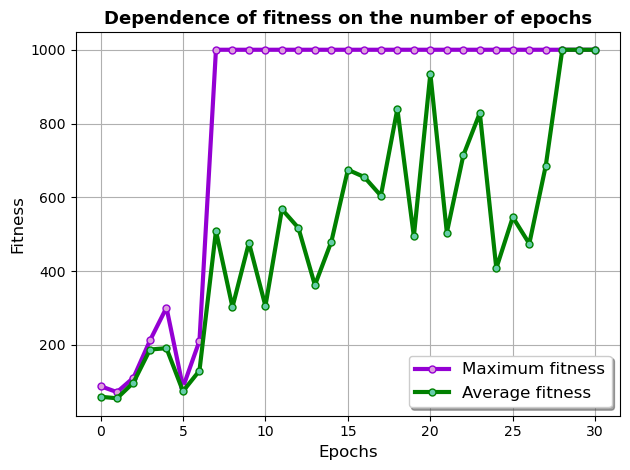

In [7]:
plt.plot(max_fit,
         label = 'Maximum fitness', 
         color = 'darkviolet', 
         linewidth = 3, 
         linestyle = 'solid', 
         marker = 'o', 
         ms = 5, 
         mec = 'darkviolet', 
         mfc = 'plum')

plt.plot(avg_fit, 
         label='Average fitness', 
         color='green', 
         linewidth=3, 
         linestyle='solid', 
         marker='o', 
         ms=5, 
         mec='green', 
         mfc='mediumaquamarine')

plt.grid()

plt.title('Dependence of fitness on the number of epochs', 
          fontweight='demibold', 
          fontsize=13)

plt.xlabel('Epochs', 
           fontsize='large', 
           fontweight='medium')

plt.ylabel('Fitness', 
           fontsize='large', 
           fontweight='medium')

plt.legend(fontsize=12, 
           shadow=True, 
           loc='best')

plt.tight_layout()
plt.show()


In [8]:
env = gym.make('CartPole-v1', render_mode="human")

model = NeuralNetworkEnsemble(nn_structures)
all_weights = []
all_biases = []
    
for ind, network in zip(best_individuals, model.networks):
    weights, biases = converting_individual(network.nn_structure, ind)
    all_weights.append(weights)
    all_biases.append(biases)

model.set_weights_and_biases(all_weights, all_biases)
    
observation, info = env.reset()
max_reward = 1000
total_reward = 0
done = False

while not done:
    action = int(model.predict(observation))
    observation, reward, done, false, info = env.step(action)
    total_reward += reward

    if total_reward > max_reward:
        print(f"Reward: > {max_reward}")
        break
else:
    print(f"Reward: {total_reward}")

env.close()


Reward: > 1000
